# Your First Neural Network

This project demonstrates how to build a neural network from scratch to predict the daily number of bike share users. While some of the setup code is provided, the focus is on implementing the neural network itself.

In [136]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

## Load and Prepare the Data

A critical step in working with neural networks is proper data preparation. When variables exist on different scales, it makes it difficult for the network to efficiently learn the correct weights. The code below loads and prepares the data for our model.

In [138]:
data_path = 'hour.csv'

rides = pd.read_csv(data_path)

In [139]:
rides.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Understanding the Data

This dataset contains the hourly count of bike riders from January 1, 2011, to December 31, 2012. The rider count is broken down into `casual` and `registered` users, with the total in the `cnt` column.

The plot below shows the number of riders over the first 10 days. The data exhibits complex patterns, with lower ridership on weekends and daily peaks corresponding to commute times. Our model will attempt to capture these patterns, as well as the influence of other features like temperature and weather.

In [140]:
rides[:24*10].plot(x='dteday', y='cnt')

<Axes: xlabel='dteday'>

### Dummy Variables

We have several categorical variables, such as season, weather, and month. To include these in our model, we need to convert them into binary dummy variables. This is straightforward to do with the pandas `get_dummies()` function.

In [141]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,True,False,...,False,False,False,False,False,False,False,False,False,True
1,0,0,0.22,0.80,0.0,8,32,40,True,False,...,False,False,False,False,False,False,False,False,False,True
2,0,0,0.22,0.80,0.0,5,27,32,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0.24,0.75,0.0,3,10,13,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0,0,0.24,0.75,0.0,0,1,1,True,False,...,False,False,False,False,False,False,False,False,False,True


### Scaling Target Variables

To make training the network easier, we will standardize each of the continuous variables. This means we will shift and scale the variables so they have a mean of zero and a standard deviation of 1. The scaling factors are saved so we can revert the predictions back to their original scale later.

In [142]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Save the scales in a dictionary so we can convert them back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
  

C:\Users\jsmar\AppData\Local\Temp\ipykernel_31436\4040778786.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.662736   -0.56132647 -0.62217218 ... -0.58160837 -0.45991693
 -0.48019884]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, each] = (data[each] - mean)/std
C:\Users\jsmar\AppData\Local\Temp\ipykernel_31436\4040778786.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.93016249 -0.80463169 -0.83766611 ... -0.46768062 -0.69892155
 -0.77159727]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, each] = (data[each] - mean)/std
C:\Users\jsmar\AppData\Local\Temp\ipykernel_31436\4040778786.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.95631172 -0.823

In [143]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,True,False,...,False,False,False,False,False,False,False,False,False,True
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,True,False,...,False,False,False,False,False,False,False,False,False,True
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,True,False,...,False,False,False,False,False,False,False,False,False,True


### Splitting the Data into Training, Testing, and Validation Sets

We will save the data from the last 21 days to use as a test set after we have trained the network. We will use this set to make predictions and compare them with the actual rider counts.

In [144]:
# Save data from approximately the last 21 days
test_data = data[-21*24:]

# Now remove the test data from the dataset
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt']#, 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

### Splitting the Data into Training, Testing, and Validation Sets

We will save the data from the last 21 days to use as a test set after we have trained the network. We will use this set to make predictions and compare them with the actual rider counts.

In [145]:
# Keep the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [146]:
train_features_np = train_features.to_numpy()
val_features_np = val_features.to_numpy()
test_features_np = test_features.to_numpy()
train_targets_np = train_targets.to_numpy()
val_targets_np = val_targets.to_numpy()
test_targets_np = test_targets.to_numpy()

In [147]:
# We use np.float32 because it's a standard type for PyTorch tensors
train_features_np = train_features.astype(np.float32).to_numpy()
val_features_np = val_features.astype(np.float32).to_numpy()
test_features_np = test_features.astype(np.float32).to_numpy()
train_targets_np = train_targets.astype(np.float32).to_numpy()
val_targets_np = val_targets.astype(np.float32).to_numpy()
test_targets_np = test_targets.astype(np.float32).to_numpy()

In [148]:
# We use np.float32 because it's a standard type for PyTorch tensors
train_tensor = torch.tensor(train_features_np, dtype=torch.float)
val_tensor = torch.tensor(val_features_np, dtype=torch.float)
test_tensor = torch.tensor(test_features_np, dtype=torch.float)
train_targets_tensor = torch.tensor(train_targets_np, dtype=torch.float)
val_targets_tensor = torch.tensor(val_targets_np, dtype=torch.float)
test_targets_tensor = torch.tensor(test_targets_np, dtype=torch.float)
train_targets_tensor.shape

torch.Size([15435, 1])

Let's define our dataset

In [149]:
# Define dataset
train_data = TensorDataset(train_tensor, train_targets_tensor)
valid_data = TensorDataset(val_tensor, val_targets_tensor)
test_data = TensorDataset(test_tensor, test_targets_tensor)

In [150]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size, shuffle=False)# shuffle=True)
valid_loader = DataLoader(valid_data, batch_size, shuffle=False)# shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)# shuffle=True)

## Time to Build the Network

Now you will build your network. The network has two hidden layers and an output layer. The hidden layers will use the ReLU activation function. The output layer has a single node and is used for regression, so its activation function is linear (f(x) = x).

In [151]:
#Define aquitectur 
class Regression(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.f1 = nn.Linear(58, 45)
        self.f2 = nn.Linear(45, 20)
        self.f3 = nn.Linear(20, 1)   
        self.reLu = nn.ReLU()

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.dropout(F.relu(self.f1(x)))
        x = self.dropout(F.relu(self.f2(x)))
        x = self.f3(x)
    
               
        return x

In [152]:
# Instantiate your model
model = Regression()
print(model)

if train_on_gpu:
    model.cuda()
    

Regression(
  (f1): Linear(in_features=58, out_features=45, bias=True)
  (f2): Linear(in_features=45, out_features=20, bias=True)
  (f3): Linear(in_features=20, out_features=1, bias=True)
  (reLu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


## Training the Network

Here, you'll set the hyperparameters for the network. The goal is to find hyperparameters that result in a low training error without overfitting the data. Overfitting occurs when the model becomes too specific to the training set and fails to generalize to the validation set.

In [153]:
lr = 0.0001
#Define the cost function
criterion = nn.MSELoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.ASGD(model.parameters(), lr=lr)



### 3. Train the Model

The model was trained for 30 epochs, as this was the point where the validation loss was at its lowest before becoming constant. We also used an "early stopping" technique to save the best-performing model during training. As seen in the output, both the training and validation losses decrease satisfactorily. 

In [154]:

epochs = 30
steps = 0
valid_loss_min = np.inf # track change in validation loss
train_losses, valid_losses  = [], []

for e in range(1, epochs+1):
 running_loss = 0
 for x_b, y_b in train_loader:
   y_pred = model(x_b)
   loss = criterion(y_pred, y_b)
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   running_loss += loss.item()
 else:        
        valid_loss =0 
             
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
             model.eval()
        for x_b, y_b in valid_loader:
                log_ps = model(x_b)
                #Reload test_loss (tracking tst loss over epochs)
                v_loss = criterion(log_ps, y_b)
                valid_loss += v_loss.item()
                     
        
        model.train()
                
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
       
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)))
        
         # save model if validation loss has decreased
 if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss  
    

Epoch: 2/30..  Training Loss: 0.685..  Valid Loss: 0.267.. 
Validation loss decreased (inf --> 24.045436).  Saving model ...
Epoch: 3/30..  Training Loss: 0.138..  Valid Loss: 0.051.. 
Validation loss decreased (24.045436 --> 4.595773).  Saving model ...
Epoch: 4/30..  Training Loss: 0.089..  Valid Loss: 0.023.. 
Validation loss decreased (4.595773 --> 2.113126).  Saving model ...
Epoch: 5/30..  Training Loss: 0.074..  Valid Loss: 0.016.. 
Validation loss decreased (2.113126 --> 1.411229).  Saving model ...
Epoch: 6/30..  Training Loss: 0.066..  Valid Loss: 0.012.. 
Validation loss decreased (1.411229 --> 1.058285).  Saving model ...
Epoch: 7/30..  Training Loss: 0.060..  Valid Loss: 0.008.. 
Validation loss decreased (1.058285 --> 0.690774).  Saving model ...
Epoch: 8/30..  Training Loss: 0.057..  Valid Loss: 0.007.. 
Validation loss decreased (0.690774 --> 0.612049).  Saving model ...
Epoch: 9/30..  Training Loss: 0.053..  Valid Loss: 0.006.. 
Validation loss decreased (0.612049 --> 

In [155]:
model.load_state_dict(torch.load('model_augmented.pt'))

C:\Users\jsmar\AppData\Local\Temp\ipykernel_31436\2777058808.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_augmented.pt'))


<All keys matched successfully>

### 4. Visualize Training and Validation Loss

Plotting the training and validation loss is an effective way to observe the model's learning progress. In the graph below, we can see that both curves descend rapidly, approaching zero, which indicates that the model is learning effectively.

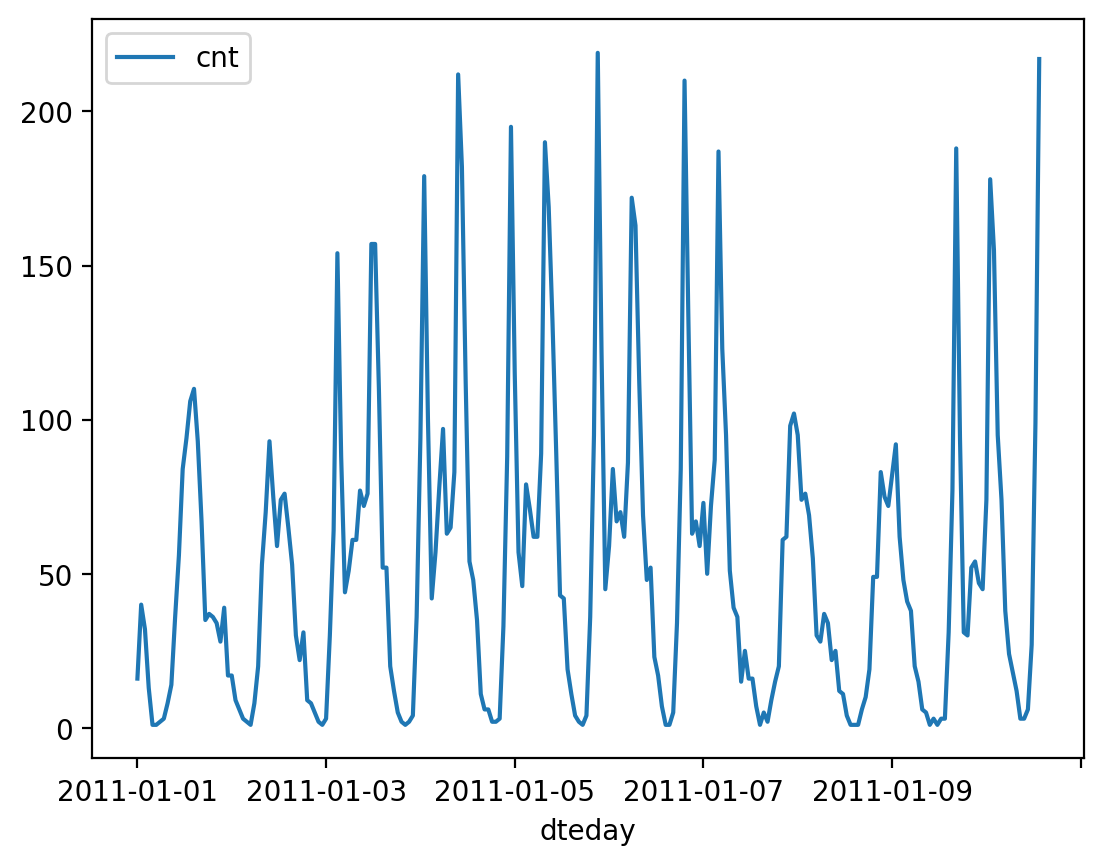

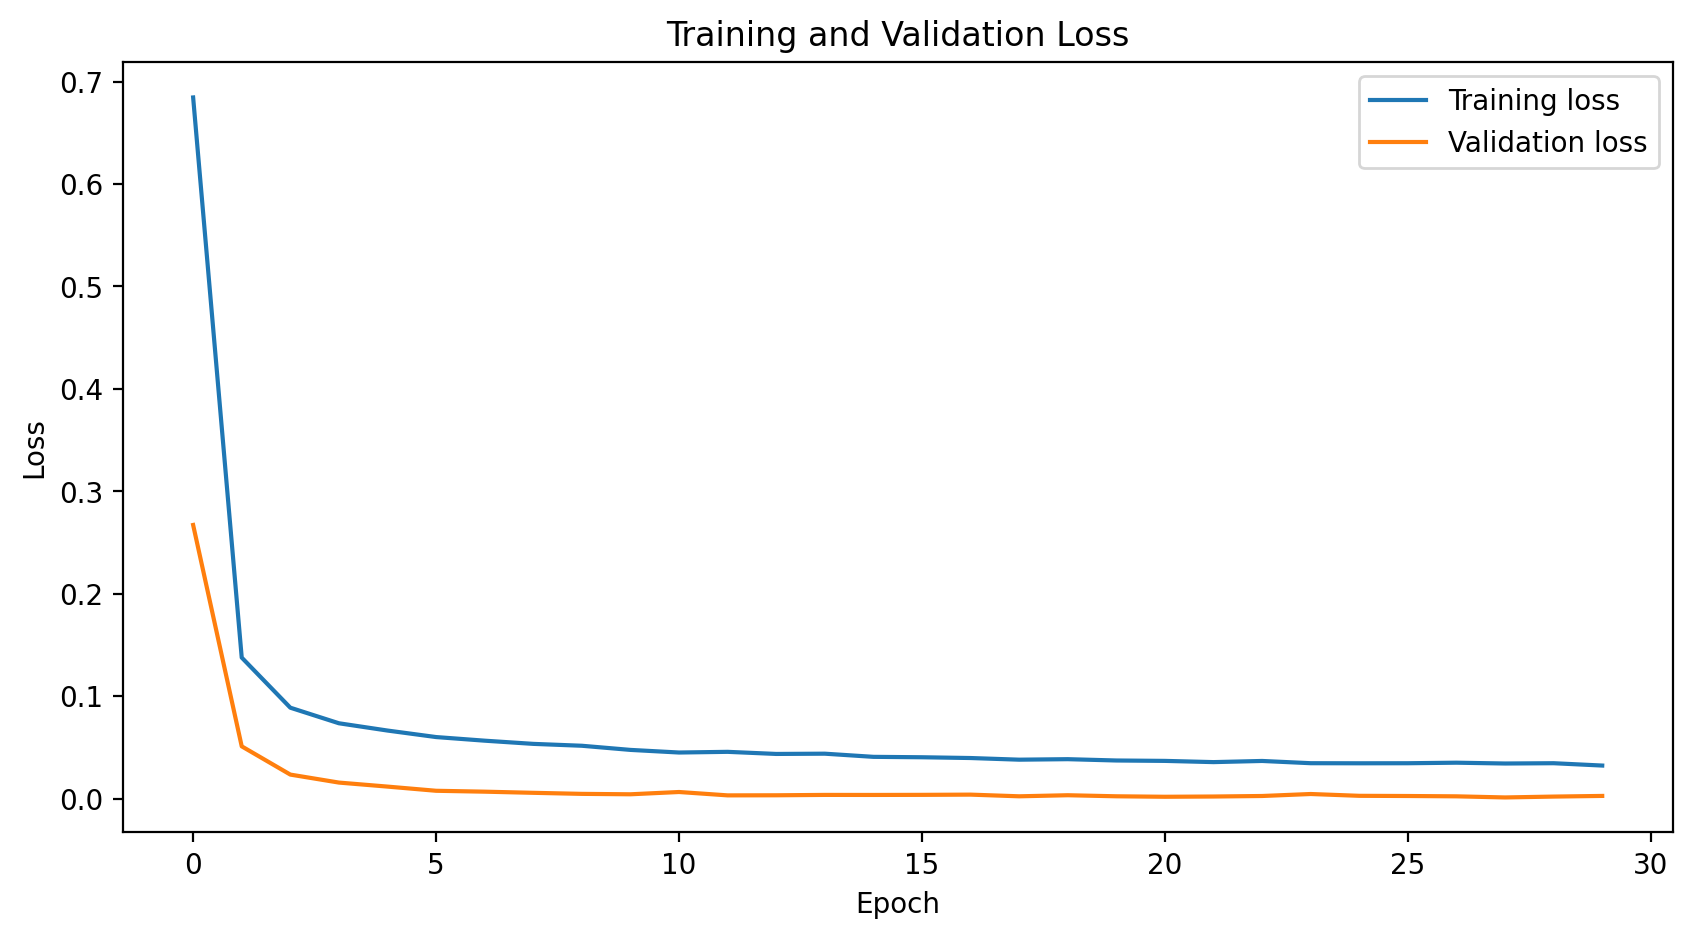

In [156]:
# Create a new figure and set its size
plt.figure(figsize=(10, 5)) 

# Add a title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot the data
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

### 5. Check Your Forecasts

Here, we use the test data to see how well our trained network is modeling the data. This step helps validate the model's performance on data it has never seen before.

In [157]:
# Pass the test data through your pre-trained model
prediccion = model(test_tensor)


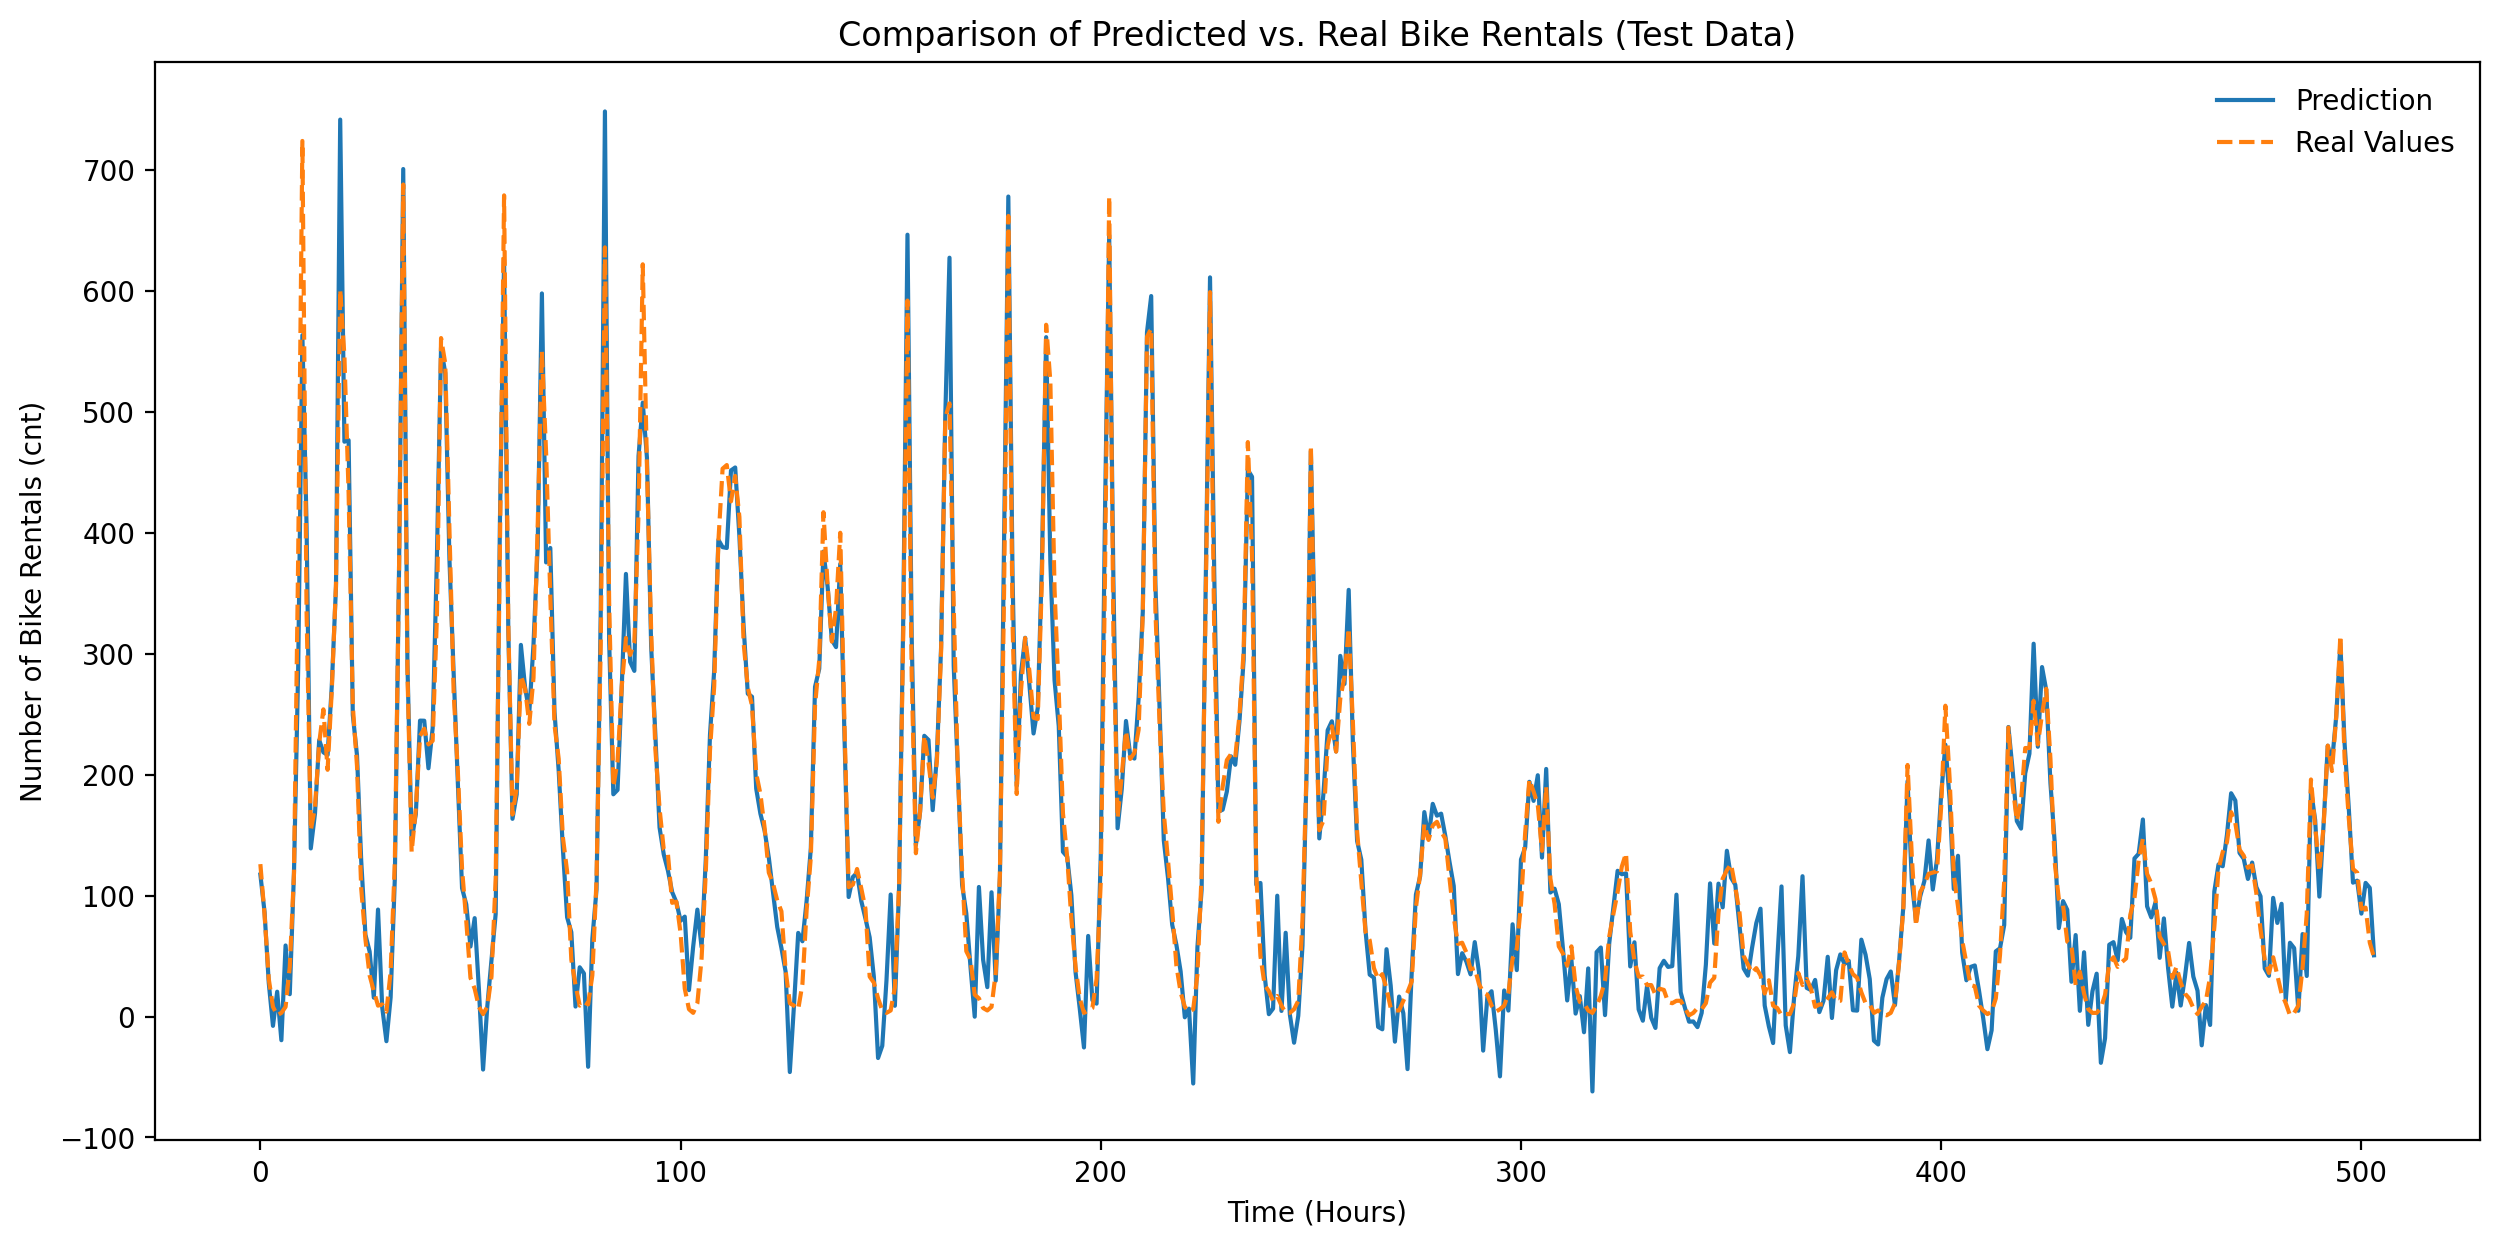

In [158]:
# --- Existing Code ---
mean, std = scaled_features['cnt']
predictions = (prediccion*std + mean).detach().numpy()
real_values = (test_targets['cnt']*std + mean).values

# --- New Lines for a Better-Looking Graph ---

# Set the figure size to make it larger and easier to read
plt.figure(figsize=(15, 7))

# Add a title to the graph
plt.title('Comparison of Predicted vs. Real Bike Rentals (Test Data)')

# Add labels to the X and Y axes
plt.xlabel('Time (Hours)')
plt.ylabel('Number of Bike Rentals (cnt)')

# --- Plot the data (same as before) ---
plt.plot(predictions, label='Prediction')
plt.plot(real_values, '--', label='Real Values')
plt.legend(frameon=False)

# --- Display the plot ---
plt.show()